In [1]:
# Import packages

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from itertools import product
from plotly.subplots import make_subplots

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
#from sklearn.preprocessing import StandardScaler #Used for KNN and Logistic Regression, which were removed for final notebook
#from sklearn.linear_model import LogisticRegression #Removed for final notebook submission
#from sklearn.neighbors import KNeighborsClassifier #Removed for final notebook submission
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier


from scipy.stats import uniform, randint
import joblib
import json
import random

In [2]:
train_series = pd.read_csv("data/train_series.csv")
train_series.head()

ID     MONTH  PAY  BILL_AMT  PAY_AMT
0  15936      JUNE  1.0       0.0    797.0
1  15936       MAY -1.0     797.0    190.0
2  15936     APRIL -1.0     190.0   3269.0
3  15936     MARCH -1.0    3260.0  32617.0
4  15936  FEBRUARY -1.0   32617.0   5000.0

In [3]:
# Pivot the table for Pay_Amt
pay_amt = train_series.pivot(columns="MONTH",index="ID",values="PAY_AMT")

columns = {'JANUARY':'PAY_AMT_JANUARY',
           'FEBRUARY': 'PAY_AMT_FEBRUARY',
           'MARCH': 'PAY_AMT_MARCH',
           'APRIL': 'PAY_AMT_APRIL',
           'MAY':'PAY_AMT_MAY',
           'JUNE':'PAY_AMT_JUNE',
           'JULY':'PAY_AMT_JULY',
           'AUGUST':'PAY_AMT_AUGUST',
           'SEPTEMBER':'PAY_AMT_SEPTEMBER',
           'OCTOBER':'PAY_AMT_OCTOBER',
           'NOVEMBER':'PAY_AMT_NOVEMBER',
           'DECEMBER':'PAY_AMT_DECEMBER'}

pay_amt.rename(columns = columns, inplace = True) 

In [4]:
# Pivot the table for Pay
pay = train_series.pivot(columns="MONTH",index="ID",values="PAY")

columns = {'JANUARY':'PAY_JANUARY',
           'FEBRUARY': 'PAY_FEBRUARY',
           'MARCH': 'PAY_MARCH',
           'APRIL': 'PAY_APRIL',
           'MAY':'PAY_MAY',
           'JUNE':'PAY_JUNE',
           'JULY':'PAY_JULY',
           'AUGUST':'PAY_AUGUST',
           'SEPTEMBER':'PAY_SEPTEMBER',
           'OCTOBER':'PAY_OCTOBER',
           'NOVEMBER':'PAY_NOVEMBER',
           'DECEMBER':'PAY_DECEMBER'}

pay.rename(columns = columns, inplace = True) 

In [5]:
# Pivot the table for Bill_Amt
bill_amt = train_series.pivot(columns="MONTH",index="ID",values="BILL_AMT")

columns = {'JANUARY':'BILL_AMT_JANUARY',
           'FEBRUARY': 'BILL_AMT_FEBRUARY',
           'MARCH': 'BILL_AMT_MARCH',
           'APRIL': 'BILL_AMT_APRIL',
           'MAY':'BILL_AMT_MAY',
           'JUNE':'BILL_AMT_JUNE',
           'JULY':'BILL_AMT_JULY',
           'AUGUST':'BILL_AMT_AUGUST',
           'SEPTEMBER':'BILL_AMT_SEPTEMBER',
           'OCTOBER':'BILL_AMT_OCTOBER',
           'NOVEMBER':'BILL_AMT_NOVEMBER',
           'DECEMBER':'BILL_AMT_DECEMBER'}

bill_amt.rename(columns = columns, inplace = True) 

In [6]:
# Concatenate these tables together horizontally based on the index
new_table = pd.concat([pay_amt, pay, bill_amt], axis=1)

In [8]:
new_table.head()

MONTH  PAY_AMT_APRIL  PAY_AMT_FEBRUARY  PAY_AMT_JANUARY  PAY_AMT_JUNE  \
ID                                                                      
0                0.0             680.0          10000.0        1300.0   
1             2000.0            1903.0           2006.0        3212.0   
3                0.0               0.0              0.0         742.0   
4              331.0             356.0            330.0        1140.0   
5             1837.0            1254.0           1387.0        2100.0   

MONTH  PAY_AMT_MARCH  PAY_AMT_MAY  PAY_APRIL  PAY_FEBRUARY  PAY_JANUARY  \
ID                                                                        
0            22373.0       1000.0        0.0          -1.0          0.0   
1             1603.0       2106.0        0.0           0.0          0.0   
3                0.0          0.0       -2.0          -2.0         -2.0   
4              341.0       1150.0        0.0           0.0          0.0   
5             1139.0       1847.0        0.0           0.0          0.0   

MONTH  PAY_JUNE  PAY_MARCH  PAY_MAY  BILL_AMT_APRIL  BILL_AMT_FEBRUARY  \
ID                                                                       
0          -1.0        0.0      0.0         13600.0            44024.0   
1           0.0        0.0      0.0         53169.0            50372.0   
3          -2.0       -2.0     -2.0             0.0                0.0   
4           0.0        0.0      0.0          9044.0             9417.0   
5           0.0        0.0      0.0         44412.0            35704.0   

MONTH  BILL_AMT_JANUARY  BILL_AMT_JUNE  BILL_AMT_MARCH  BILL_AMT_MAY  
ID                                                                    
0               18697.0        28991.0             0.0       24391.0  
1               49470.0        75662.0         50875.0       70073.0  
3                   0.0        23570.0             0.0         735.0  
4                9617.0         8214.0          9225.0        8034.0  
5               36524.0        50840.0         45402.0       49592.0

In [7]:
train_cust = pd.read_csv("data/train_customers.csv")
train_cust.head()

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE
0  15936   140000.0    2          1         1   39
1  15248    90000.0    2          2         1   49
2  27163   150000.0    2          1         1   37
3  13955   160000.0    1          3         1   38
4  23604   360000.0    1          2         1   28

In [8]:
# Set the index of this table to ID
train_cust = train_cust.set_index("ID")

In [9]:
# Concatenate horizontally with the time series data
full_table = pd.concat([new_table, train_cust], axis=1)

In [12]:
full_table.head()

PAY_AMT_APRIL  PAY_AMT_FEBRUARY  PAY_AMT_JANUARY  PAY_AMT_JUNE  \
ID                                                                   
0             0.0             680.0          10000.0        1300.0   
1          2000.0            1903.0           2006.0        3212.0   
3             0.0               0.0              0.0         742.0   
4           331.0             356.0            330.0        1140.0   
5          1837.0            1254.0           1387.0        2100.0   

    PAY_AMT_MARCH  PAY_AMT_MAY  PAY_APRIL  PAY_FEBRUARY  PAY_JANUARY  \
ID                                                                     
0         22373.0       1000.0        0.0          -1.0          0.0   
1          1603.0       2106.0        0.0           0.0          0.0   
3             0.0          0.0       -2.0          -2.0         -2.0   
4           341.0       1150.0        0.0           0.0          0.0   
5          1139.0       1847.0        0.0           0.0          0.0   

    PAY_JUNE  ...  BILL_AMT_FEBRUARY  BILL_AMT_JANUARY  BILL_AMT_JUNE  \
ID            ...                                                       
0       -1.0  ...            44024.0           18697.0        28991.0   
1        0.0  ...            50372.0           49470.0        75662.0   
3       -2.0  ...                0.0               0.0        23570.0   
4        0.0  ...             9417.0            9617.0         8214.0   
5        0.0  ...            35704.0           36524.0        50840.0   

    BILL_AMT_MARCH  BILL_AMT_MAY  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  
ID                                                                          
0              0.0       24391.0    40000.0    2          2         2   26  
1          50875.0       70073.0    80000.0    2          3         1   59  
3              0.0         735.0   200000.0    2          2         1   41  
4           9225.0        8034.0    50000.0    1          2         1   43  
5          45402.0       49592.0    60000.0    2          2         2   24  

[5 rows x 23 columns]

In [10]:
train_target = pd.read_csv("data/train_target.csv")
train_target.head()

ID  DEFAULT_JULY
0  15936             0
1  15248             1
2  27163             0
3  13955             0
4  23604             0

In [11]:
# Set the index of this table to ID
train_target = train_target.set_index("ID")

In [12]:
# Concatenate horizontally with the previous table
A_train = pd.concat([full_table, train_target], axis=1)

In [35]:
A_train.head()

PAY_AMT_APRIL  PAY_AMT_FEBRUARY  PAY_AMT_JANUARY  PAY_AMT_JUNE  \
ID                                                                   
0             0.0             680.0          10000.0        1300.0   
1          2000.0            1903.0           2006.0        3212.0   
3             0.0               0.0              0.0         742.0   
4           331.0             356.0            330.0        1140.0   
5          1837.0            1254.0           1387.0        2100.0   

    PAY_AMT_MARCH  PAY_AMT_MAY  PAY_APRIL  PAY_FEBRUARY  PAY_JANUARY  \
ID                                                                     
0         22373.0       1000.0        0.0          -1.0          0.0   
1          1603.0       2106.0        0.0           0.0          0.0   
3             0.0          0.0       -2.0          -2.0         -2.0   
4           341.0       1150.0        0.0           0.0          0.0   
5          1139.0       1847.0        0.0           0.0          0.0   

    PAY_JUNE  ...  BILL_AMT_JANUARY  BILL_AMT_JUNE  BILL_AMT_MARCH  \
ID            ...                                                    
0       -1.0  ...           18697.0        28991.0             0.0   
1        0.0  ...           49470.0        75662.0         50875.0   
3       -2.0  ...               0.0        23570.0             0.0   
4        0.0  ...            9617.0         8214.0          9225.0   
5        0.0  ...           36524.0        50840.0         45402.0   

    BILL_AMT_MAY  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  DEFAULT_JULY  
ID                                                                        
0        24391.0    40000.0    2          2         2   26             0  
1        70073.0    80000.0    2          3         1   59             0  
3          735.0   200000.0    2          2         1   41             1  
4         8034.0    50000.0    1          2         1   43             0  
5        49592.0    60000.0    2          2         2   24             0  

[5 rows x 24 columns]

In [25]:
A_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PAY_AMT_APRIL      15000 non-null  float64
 1   PAY_AMT_FEBRUARY   15000 non-null  float64
 2   PAY_AMT_JANUARY    15000 non-null  float64
 3   PAY_AMT_JUNE       15000 non-null  float64
 4   PAY_AMT_MARCH      15000 non-null  float64
 5   PAY_AMT_MAY        15000 non-null  float64
 6   PAY_APRIL          15000 non-null  float64
 7   PAY_FEBRUARY       15000 non-null  float64
 8   PAY_JANUARY        15000 non-null  float64
 9   PAY_JUNE           15000 non-null  float64
 10  PAY_MARCH          15000 non-null  float64
 11  PAY_MAY            15000 non-null  float64
 12  BILL_AMT_APRIL     15000 non-null  float64
 13  BILL_AMT_FEBRUARY  15000 non-null  float64
 14  BILL_AMT_JANUARY   15000 non-null  float64
 15  BILL_AMT_JUNE      15000 non-null  float64
 16  BILL_AMT_MARCH     15000 no

In [36]:
A_train.to_csv('BadeKatherine_A_train.csv',header=True,index=True)

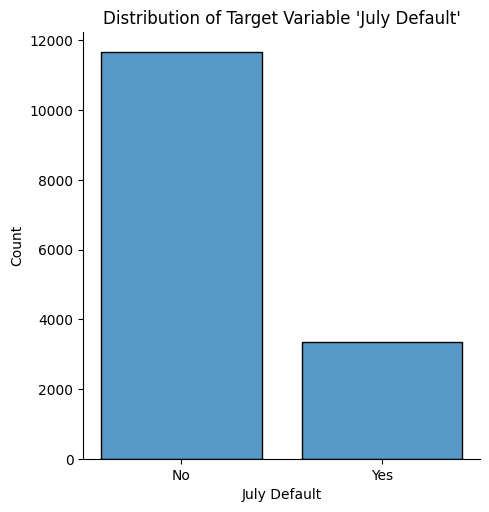

In [14]:
sns.displot(A_train, x="DEFAULT_JULY",bins=2,shrink=0.8)
plt.xticks(ticks=[0.25,0.75],labels=['No','Yes'],ha='center')
plt.xlabel("July Default")
plt.title("Distribution of Target Variable 'July Default'")
plt.show()

# This is an imbalanced dataset but not horribly so. There are far more DEFAULT_JULY = 0 than = 1, but there are still a good number of 1s as well.

In [15]:
# Split into categorical and numeric 
categorical = ["SEX","EDUCATION","MARRIAGE",'PAY_APRIL','PAY_FEBRUARY','PAY_JANUARY','PAY_JUNE','PAY_MARCH','PAY_MAY']
numeric = ['PAY_AMT_FEBRUARY','PAY_AMT_JANUARY','PAY_AMT_JUNE','PAY_AMT_MARCH','PAY_AMT_MAY','BILL_AMT_APRIL','BILL_AMT_FEBRUARY','BILL_AMT_JANUARY','BILL_AMT_JUNE','BILL_AMT_MARCH','BILL_AMT_MAY','LIMIT_BAL','AGE']

In [16]:
# Turn DEFAULT_JULY into a string so it can be plotted using barmode=group
proxy = A_train.copy()
proxy['DEFAULT_JULY'] = proxy['DEFAULT_JULY'].astype(str)

# Change categorical variables from numeric indicators to what they stand for, so labels show up nicely on the following plots
def sex(input):
    if input == 1:
        return 'Male'
    elif input == 2:
        return 'Female'

proxy['SEX'] = proxy['SEX'].apply(sex)

def education(input):
    if input == 1:
        return '1. Graduate School'
    elif input == 2:
        return '2. University'
    elif input == 3:
        return '3. High School'
    elif input == 4:
        return '4. Other'
    else:
        return '5. Unknown'

proxy['EDUCATION'] = proxy['EDUCATION'].apply(education)

def marital(input):
    if input == 1:
        return '1. Married'
    elif input == 2:
        return '2. Single'
    else:
        return '3. Other'

proxy['MARRIAGE'] = proxy['MARRIAGE'].apply(marital)

def pay(input):
    if input == -2:
        return '1. Zero Balance'
    elif input == -1:
        return '2. Pay Duly'
    elif input == 0:
        return '3. Revolving Credit'
    elif input == 1:
        return '4. One Month Delay'
    elif input == 2:
        return '5. Two Month Delay'
    elif input == 3:
        return '6. Three Month Delay'
    elif input == 4:
        return '7. Four Month Delay'
    elif input == 5:
        return '8. Five Month Delay'
    elif input == 6:
        return '9. Six Month Delay'
    elif input == 7:
        return '10. Seven Month Delay'
    elif input == 8:
        return '11. Eight Month Delay'
    else:
        return '12. Nine + Month Delay'

proxy['PAY_JANUARY'] = proxy['PAY_JANUARY'].apply(pay)
proxy['PAY_FEBRUARY'] = proxy['PAY_FEBRUARY'].apply(pay)
proxy['PAY_MARCH'] = proxy['PAY_MARCH'].apply(pay)
proxy['PAY_APRIL'] = proxy['PAY_APRIL'].apply(pay)
proxy['PAY_MAY'] = proxy['PAY_MAY'].apply(pay)
proxy['PAY_JUNE'] = proxy['PAY_JUNE'].apply(pay)

In [21]:
# Plot distribution of categorical variables split by DEFAULT_JULY
comb = product(list(range(3)),list(range(3)))
fig = make_subplots(rows=3, cols=3, subplot_titles=proxy[categorical].columns[:])

for column,(row,col) in zip(proxy[categorical].columns[:], comb):
    aux = proxy.groupby([column,"DEFAULT_JULY"]).size()
    aux.name = "value"
    aux = aux.sort_values(ascending = False) 
    fig.add_traces(px.bar(aux.reset_index(), x=column, y="value", color="DEFAULT_JULY", barmode="group")["data"], rows=row+1, cols=col+1)
    fig.update_yaxes(title_text="Count", row=row + 1, col=col + 1)

fig.update_layout(title_text="Distribution of Categorical Variables", height=1200, showlegend=False, template="none")

# Relatively speaking, higher education = lower chances of default
# Higher proportion of those with payment delays of any kind end up defaulting

In [23]:
# Plot distribution of numeric variables split by DEFAULT_JULY
comb = product(list(range(3)),list(range(5)))
fig = make_subplots(rows=3, cols=5, subplot_titles=A_train[numeric].columns[:])

for column,(row,col) in zip(A_train[numeric].columns[:], comb):
    fig.add_traces(px.box(A_train, x="DEFAULT_JULY", y=column, template="none")["data"], rows=row+1, cols=col+1)
    fig.update_xaxes(title_text="DEFAULT_JULY", row=row + 1, col=col + 1)
    fig.update_yaxes(title_text="PAY_AMT Sum", row=row + 1, col=col + 1)

fig.update_layout(title_text="Distribution of Numeric Variables", height=1000, showlegend=False, template="none")

# PAY_AMT and BILL_AMT are heavily weighted towards the low end of the distribution - the vast majority of payments and bills are relatively small amounts
# Median age is the same for both those who default and those who do not
# Those who do not default tend to have a higher balance limit (150k) vs. those who do default (90k)

In [24]:
fig = px.scatter_3d(A_train, x="EDUCATION", y="LIMIT_BAL", z="BILL_AMT_JUNE", color="DEFAULT_JULY")
fig.show()

# Relatively speaking, there appear to be a higher proportion of July defaulters out of those who have a high bill amount in June
# Those with higher education appear to default proportionally less

In [13]:
submission_features = pd.read_csv("data/submission_features.csv")
submission_features.head()

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_JUNE  PAY_MAY  \
0   3644   130000.0    2          1         1   46         0        0   
1  15370   120000.0    2          5         1   57         0        0   
2  15570   500000.0    1          1         1   55         3        2   
3  16113    60000.0    1          2         2   28         2        2   
4  14220   220000.0    2          1         2   36         0        0   

   PAY_APRIL  PAY_MARCH  ...  BILL_AMT_APRIL  BILL_AMT_MARCH  \
0          0          0  ...         18932.0         22001.0   
1          0          0  ...         98109.0         74387.0   
2          2          2  ...          4957.0          4957.0   
3          2          0  ...         59892.0         60228.0   
4          2          0  ...          1522.0          5198.0   

   BILL_AMT_FEBRUARY  BILL_AMT_JANUARY  PAY_AMT_JUNE  PAY_AMT_MAY  \
0             3403.0            3859.0        1593.0       3000.0   
1            75237.0           78967.0        5000.0       5007.0   
2             4957.0            4957.0           0.0          0.0   
3            57969.0           55220.0        2800.0          0.0   
4             3974.0             -38.0        2190.0          1.0   

   PAY_AMT_APRIL  PAY_AMT_MARCH  PAY_AMT_FEBRUARY  PAY_AMT_JANUARY  
0         4000.0            0.0            3860.0            249.0  
1         5000.0         5000.0            5000.0           5000.0  
2            0.0            0.0               0.0              0.0  
3         3000.0         3000.0            3000.0          23000.0  
4         3980.0           20.0               0.0           7762.0  

[5 rows x 24 columns]

In [14]:
# Split training data into X and y
X_train = A_train.drop(["DEFAULT_JULY"],axis=1).values 
y_train = A_train["DEFAULT_JULY"].values

In [15]:
# Upload test data
test = pd.read_csv("data/test_data.csv")
test.head()

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_JUNE  PAY_MAY  \
0   7077   280000.0    2          1         2   29        -1       -1   
1   2924   170000.0    1          1         2   26        -1       -1   
2  24780   230000.0    2          3         1   37         1       -2   
3   7200   140000.0    2          3         1   38         2        2   
4  20591   150000.0    2          3         1   40        -1       -1   

   PAY_APRIL  PAY_MARCH  ...  BILL_AMT_MARCH  BILL_AMT_FEBRUARY  \
0         -1         -1  ...          1885.0              143.0   
1         -1         -1  ...          1591.0             3524.0   
2         -2         -2  ...             0.0             2533.0   
3          2          0  ...        120435.0           139795.0   
4         -1         -1  ...          5876.0             5496.0   

   BILL_AMT_JANUARY  PAY_AMT_JUNE  PAY_AMT_MAY  PAY_AMT_APRIL  PAY_AMT_MARCH  \
0            1250.0         788.0       1383.0         1890.0          143.0   
1            8545.0        1512.0       1362.0         1591.0         3524.0   
2               0.0           0.0          0.0            0.0         2533.0   
3          142950.0        6000.0          0.0         5000.0        21500.0   
4            5116.0        5876.0       5956.0         5876.0         5496.0   

   PAY_AMT_FEBRUARY  PAY_AMT_JANUARY  DEFAULT_JULY  
0            1253.0            316.0             0  
1            8545.0           1485.0             0  
2               0.0            500.0             0  
3            5500.0              0.0             0  
4            5116.0           5496.0             0  

[5 rows x 25 columns]

In [16]:
# Reorder the test dataset and submission features columns to align with the train set order
submission_features = submission_features.loc[:,['ID', 'PAY_AMT_APRIL', 'PAY_AMT_FEBRUARY', 'PAY_AMT_JANUARY',
       'PAY_AMT_JUNE', 'PAY_AMT_MARCH', 'PAY_AMT_MAY', 'PAY_APRIL',
       'PAY_FEBRUARY', 'PAY_JANUARY', 'PAY_JUNE', 'PAY_MARCH', 'PAY_MAY',
       'BILL_AMT_APRIL', 'BILL_AMT_FEBRUARY', 'BILL_AMT_JANUARY',
       'BILL_AMT_JUNE', 'BILL_AMT_MARCH', 'BILL_AMT_MAY', 'LIMIT_BAL', 'SEX',
       'EDUCATION', 'MARRIAGE', 'AGE']]

test = test.loc[:,['ID', 'PAY_AMT_APRIL', 'PAY_AMT_FEBRUARY', 'PAY_AMT_JANUARY',
       'PAY_AMT_JUNE', 'PAY_AMT_MARCH', 'PAY_AMT_MAY', 'PAY_APRIL',
       'PAY_FEBRUARY', 'PAY_JANUARY', 'PAY_JUNE', 'PAY_MARCH', 'PAY_MAY',
       'BILL_AMT_APRIL', 'BILL_AMT_FEBRUARY', 'BILL_AMT_JANUARY',
       'BILL_AMT_JUNE', 'BILL_AMT_MARCH', 'BILL_AMT_MAY', 'LIMIT_BAL', 'SEX',
       'EDUCATION', 'MARRIAGE', 'AGE', "DEFAULT_JULY"]]

In [17]:
# Set index to ID
test = test.set_index("ID")

In [18]:
# Split testing data into X and y
X_test = test.drop(["DEFAULT_JULY"],axis=1).values 
y_test = test["DEFAULT_JULY"].values

Try Decision Tree first.

In [44]:
model = DecisionTreeClassifier(random_state=42)
model = model.fit(X_train,y_train)

In [27]:
# AUC of 0.6136
cvs = cross_val_score(model, X_train, y_train, scoring='roc_auc')
print(f"{round(np.mean(cvs),4)} AUC")

0.6136 AUC


Use GridSearchCV to improve metrics.

In [45]:
param_grid = {'max_depth': range(1,16)}

crossval = GridSearchCV(model, 
                   param_grid,
                   scoring='roc_auc',
                   cv=5 , n_jobs=1, verbose=1)

crossval.fit(X_train,y_train);

Fitting 5 folds for each of 15 candidates, totalling 75 fits


In [46]:
# Depth of 6 has AUC of 0.744
print("Best parameters set found on train set:")
print()
print(crossval.best_params_)
print()
print("Grid scores on train set:")
print()
means = crossval.cv_results_['mean_test_score']
stds = crossval.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, crossval.cv_results_['params']):
    print("AUC = %0.3f (+/%0.03f) for %r" % (mean, std * 2, params))

Best parameters set found on train set:

{'max_depth': 6}

Grid scores on train set:

AUC = 0.643 (+/0.013) for {'max_depth': 1}
AUC = 0.693 (+/0.016) for {'max_depth': 2}
AUC = 0.727 (+/0.018) for {'max_depth': 3}
AUC = 0.740 (+/0.018) for {'max_depth': 4}
AUC = 0.742 (+/0.015) for {'max_depth': 5}
AUC = 0.744 (+/0.013) for {'max_depth': 6}
AUC = 0.740 (+/0.022) for {'max_depth': 7}
AUC = 0.726 (+/0.014) for {'max_depth': 8}
AUC = 0.716 (+/0.023) for {'max_depth': 9}
AUC = 0.696 (+/0.025) for {'max_depth': 10}
AUC = 0.680 (+/0.021) for {'max_depth': 11}
AUC = 0.662 (+/0.025) for {'max_depth': 12}
AUC = 0.648 (+/0.038) for {'max_depth': 13}
AUC = 0.635 (+/0.039) for {'max_depth': 14}
AUC = 0.621 (+/0.029) for {'max_depth': 15}


Next, try Random Forest Classifier.

In [17]:
random_forest = RandomForestClassifier(random_state=42, max_features='sqrt')  
random_forest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [34]:
# AUC of 0.6136
cvs_rf = cross_val_score(random_forest, X_train, y_train, scoring='roc_auc')
print(f"{round(np.mean(cvs),4)} AUC")

0.6136 AUC


Let's then cross-validate to try to improve metrics.

In [49]:
param_grid = {'max_depth': range(1,16)}

crossval_rf = GridSearchCV(random_forest, 
                   param_grid,
                   scoring='roc_auc',
                   cv=5 , n_jobs=1, verbose=1)

crossval_rf.fit(X_train,y_train);

Fitting 5 folds for each of 15 candidates, totalling 75 fits


In [50]:
# At depth of 9, train AUC of 0.777
print("Best parameters set found on train set:")
print()
print(crossval_rf.best_params_)
print()
print("Grid scores on train set:")
print()
means = crossval_rf.cv_results_['mean_test_score']
stds = crossval_rf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, crossval_rf.cv_results_['params']):
    print("AUC = %0.3f (+/%0.03f) for %r" % (mean, std * 2, params))

Best parameters set found on train set:

{'max_depth': 9}

Grid scores on train set:

AUC = 0.760 (+/0.012) for {'max_depth': 1}
AUC = 0.764 (+/0.011) for {'max_depth': 2}
AUC = 0.767 (+/0.011) for {'max_depth': 3}
AUC = 0.769 (+/0.010) for {'max_depth': 4}
AUC = 0.771 (+/0.009) for {'max_depth': 5}
AUC = 0.773 (+/0.008) for {'max_depth': 6}
AUC = 0.774 (+/0.009) for {'max_depth': 7}
AUC = 0.776 (+/0.008) for {'max_depth': 8}
AUC = 0.777 (+/0.009) for {'max_depth': 9}
AUC = 0.776 (+/0.008) for {'max_depth': 10}
AUC = 0.776 (+/0.012) for {'max_depth': 11}
AUC = 0.774 (+/0.013) for {'max_depth': 12}
AUC = 0.773 (+/0.011) for {'max_depth': 13}
AUC = 0.772 (+/0.013) for {'max_depth': 14}
AUC = 0.772 (+/0.017) for {'max_depth': 15}


In [142]:
# 77.6 test AUC
cvs = cross_val_score(crossval_rf.best_estimator_, X_test, y_test, scoring='roc_auc')
print(f"{round(np.mean(cvs),4)} test AUC")

0.7759 test AUC


Try tuning hyperparameters more.

In [41]:
param_grid = {'max_depth': range(8,15),
              'n_estimators': range(200,2000,100),
              'max_features': ['sqrt', 'log2']
              #'min_samples_leaf': 
              #'min_impurity_decreases':
              }

crossval_rf = RandomizedSearchCV(random_forest, 
                   param_grid,
                   scoring='roc_auc',
                   cv=5 , n_jobs=1, verbose=1)

crossval_rf.fit(X_train,y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [42]:
best_est = crossval_rf.best_estimator_
best_est.fit(X_train,y_train)

cvs = cross_val_score(best_est, X_train, y_train, scoring='roc_auc')
print(f"{round(np.mean(cvs),4)} train AUC")

cvs = cross_val_score(best_est, X_test, y_test, scoring='roc_auc')
print(f"{round(np.mean(cvs),4)} test AUC")

0.7774 train AUC
0.7766 test AUC


In [44]:
# Save model - this submission is submission6.csv 
joblib.dump(best_est,"randomforest3.pkl")

['randomforest3.pkl']

In [43]:
crossval_rf.best_params_

{'n_estimators': 1900, 'max_features': 'log2', 'max_depth': 10}

In [ ]:
# Create test predictions
# THIS FILE HAS THE FINAL, BEST KAGGLE SCORE.
features = submission_features.drop(columns=['ID']).values
test_predictions = best_est.predict_proba(features)[:, 1]

submission = pd.DataFrame({'ID': submission_features['ID'], 'DEFAULT_JULY': test_predictions})

submission.to_csv('submission6.csv', index=False)

**FINAL NOTE (added just before submission of project): After trying the following methods, the above submission has the best Kaggle score and is therefore the "final" submission and model.**

Next, let's try bagging.

In [55]:
bagging = RandomForestClassifier(random_state=42, max_features=len(columns))
bagging.fit(X_train,y_train)

RandomForestClassifier(max_features=12, random_state=42)

In [56]:
# AUC of 0.6136
cvs_bag = cross_val_score(bagging, X_train, y_train, scoring='roc_auc')
print(f"{round(np.mean(cvs),4)} AUC")

0.6136 AUC


Then, try GridSearchCV.

In [58]:
param_grid = {'max_depth': range(1,16)}

crossval_bag = GridSearchCV(bagging, 
                   param_grid,
                   scoring='roc_auc',
                   cv=5 , n_jobs=1, verbose=1)

crossval_bag.fit(X_train,y_train);

Fitting 5 folds for each of 15 candidates, totalling 75 fits


In [59]:
# At depth of 7, AUC of 0.775
print("Best parameters set found on train set:")
print()
print(crossval_bag.best_params_)
print()
print("Grid scores on train set:")
print()
means = crossval_bag.cv_results_['mean_test_score']
stds = crossval_bag.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, crossval_bag.cv_results_['params']):
    print("AUC = %0.3f (+/%0.03f) for %r" % (mean, std * 2, params))

Best parameters set found on train set:

{'max_depth': 7}

Grid scores on train set:

Accuracy = 0.752 (+/0.008) for {'max_depth': 1}
Accuracy = 0.763 (+/0.014) for {'max_depth': 2}
Accuracy = 0.762 (+/0.015) for {'max_depth': 3}
Accuracy = 0.767 (+/0.013) for {'max_depth': 4}
Accuracy = 0.771 (+/0.010) for {'max_depth': 5}
Accuracy = 0.773 (+/0.007) for {'max_depth': 6}
Accuracy = 0.775 (+/0.008) for {'max_depth': 7}
Accuracy = 0.775 (+/0.008) for {'max_depth': 8}
Accuracy = 0.775 (+/0.009) for {'max_depth': 9}
Accuracy = 0.774 (+/0.011) for {'max_depth': 10}
Accuracy = 0.774 (+/0.012) for {'max_depth': 11}
Accuracy = 0.772 (+/0.014) for {'max_depth': 12}
Accuracy = 0.771 (+/0.016) for {'max_depth': 13}
Accuracy = 0.768 (+/0.016) for {'max_depth': 14}
Accuracy = 0.768 (+/0.017) for {'max_depth': 15}


After trying several decision trees, the best model so far is a Random Forest Classifier with the following hyperparameters: {'n_estimators': 1900, 'max_features': 'log2', 'max_depth': 10}
This model has an AUC of 0.7774 on the train dataset.

I tried Logistic Regression and KNN next, but for cleanliness of the submitted file, I removed them from the final submission because scores were significantly lower than with other options.

Let's try a more methodical approach to tuning hyperparameters to see if we can improve AUC.

In [19]:
# Try plotting for ideal n_estimators - this code is modified from code found online while researching hyperparameter tuning techniques
def n_estimator_error(md):
    model = RandomForestClassifier(n_estimators=md, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    train_AUC = 1 - roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
    test_AUC = 1 - roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    return {'N_Estimators': md, 'Training Error': train_AUC, 'Test Error': test_AUC}

In [126]:
# Changed the values in the range several times to key in on where test error was lowest
errors_df = pd.DataFrame([n_estimator_error(md) for md in range(4000,5500,100)])

# We will use 4900, as the lowest test error
errors_df

N_Estimators  Training Error  Test Error
0           4000    4.620987e-07    0.389022
1           4100    4.620987e-07    0.390708
2           4200    4.620987e-07    0.390544
3           4300    4.620987e-07    0.389512
4           4400    4.620987e-07    0.388588
5           4500    4.620987e-07    0.389379
6           4600    4.620987e-07    0.391641
7           4700    4.620987e-07    0.388717
8           4800    4.620987e-07    0.387569
9           4900    4.620987e-07    0.387130
10          5000    4.620987e-07    0.387280
11          5100    4.620987e-07    0.388174
12          5200    4.620987e-07    0.390489
13          5300    4.620987e-07    0.389671
14          5400    4.620987e-07    0.390875

In [143]:
# Try plotting for ideal max_leaf_nodes
def max_leaf_error(md):
    model = RandomForestClassifier(max_leaf_nodes=md, n_estimators=4900, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    train_AUC = 1 - roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
    test_AUC = 1 - roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    return {'Max Leaf Nodes': md, 'Training Error': train_AUC, 'Test Error': test_AUC}

In [148]:
errors_df = pd.DataFrame([max_leaf_error(md) for md in range(26,38,2)])

# 30 seems to be the best choice for max_leaf_nodes
errors_df

Max Leaf Nodes  Training Error  Test Error
0              26        0.210368    0.321099
1              28        0.208872    0.321210
2              30        0.207442    0.320948
3              32        0.206083    0.321375
4              34        0.204693    0.321819
5              36        0.203327    0.323193

In [158]:
# Combine these parameters into a model
model = RandomForestClassifier(max_leaf_nodes=30, n_estimators=4900, n_jobs=-1, random_state=42)
model.fit(X_train,y_train)

RandomForestClassifier(max_leaf_nodes=30, n_estimators=4900, n_jobs=-1,
                       random_state=42)

In [150]:
# Best so far on test set
cvs = cross_val_score(model, X_train, y_train, scoring='roc_auc')
print(f"{round(np.mean(cvs),4)} train AUC")

cvs = cross_val_score(model, X_test, y_test, scoring='roc_auc')
print(f"{round(np.mean(cvs),4)} test AUC")

0.7742 train AUC
0.7786 test AUC


In [152]:
# Save model - this model was used for submission5
joblib.dump(model,"RandomForest2.pkl")

['RandomForest2.pkl']

In [25]:
model = joblib.load("RandomForest2.pkl")
model.fit(X_train,y_train)

RandomForestClassifier(max_leaf_nodes=30, n_estimators=4900, n_jobs=-1,
                       random_state=42)

In [36]:
# Create test predictions
features = submission_features.drop(columns=['ID']).values
test_predictions = model.predict_proba(features)[:, 1]

submission = pd.DataFrame({'ID': submission_features['ID'], 'DEFAULT_JULY': test_predictions})

submission.to_csv('submission5.csv', index=False)

Let's try XGBoost now.

In [133]:
# Solid starting point with AUC.
xgb_tree = xgb.XGBClassifier(objective="binary:logistic", verbosity=0, random_state=42)
xgb_tree.fit(X_train,y_train)

cvs = cross_val_score(xgb_tree, X_train, y_train, scoring='roc_auc')
print(f"{round(np.mean(cvs),4)} AUC")

0.7561 AUC


Let's try hyperparameter tuning.

In [135]:
params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3),
    "max_depth": randint(2, 6),
    "n_estimators": randint(100, 150),
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_tree, param_distributions=params, random_state=42, n_iter=50, scoring='roc_auc', cv=5, verbose=1, n_jobs=1, return_train_score=True)
search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=0.9744593170661344,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=0.1850793501277222,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_co...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000026BEC02E750>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000026BEC1F7E10>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000026BEC1FCE50>},
                   random_state=42, return_train_score=True, scoring='roc_auc',
                   verbose=1)

In [136]:
# Slightly improved - nice!
best_est = search.best_estimator_
best_est.fit(X_train,y_train)

cvs = cross_val_score(best_est, X_train, y_train, scoring='roc_auc')
print(f"{round(np.mean(cvs),4)} train AUC")

cvs = cross_val_score(best_est, X_test, y_test, scoring='roc_auc')
print(f"{round(np.mean(cvs),4)} test AUC")

0.7792 train AUC
0.78 test AUC


In [137]:
# Save model - this submission is submission7.csv 
joblib.dump(best_est,"randomforest4.pkl")

['randomforest4.pkl']

In [138]:
model = joblib.load("randomforest4.pkl")
model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9744593170661344, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1850793501277222, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03463698495866023, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=128, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [139]:
# This model did slightly worse in Kaggle
test_predictions = model.predict_proba(submission_features.drop(columns=['ID']))[:, 1]
submission = pd.DataFrame({'ID': submission_features['ID'], 'DEFAULT_JULY': test_predictions})
submission.to_csv('submission7.csv', index=False)

Let's try training our Random Forest Classifier on the train data AND the test data, to increase the dataset that it is training on.

In [181]:
total_data = pd.concat([A_train, test])

In [185]:
X = total_data.drop(columns=["DEFAULT_JULY"])
y = total_data["DEFAULT_JULY"]

In [188]:
model = joblib.load("randomforest3.pkl")
model.fit(X,y)

RandomForestClassifier(max_leaf_nodes=30, n_estimators=4900, n_jobs=-1,
                       random_state=42)

In [ ]:
cvs = cross_val_score(model, X, y, scoring='roc_auc')
print(f"{round(np.mean(cvs),4)} AUC")

In [189]:
# This did not improve Kaggle score. Let's move on.
test_predictions = model.predict_proba(submission_features.drop(columns=['ID']))[:, 1]
submission = pd.DataFrame({'ID': submission_features['ID'], 'DEFAULT_JULY': test_predictions})
submission.to_csv('submission10.csv', index=False)

Try LGBM next.

In [125]:
lgbm = LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 3341, number of negative: 11659
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3257
[LightGBM] [Info] Number of data points in the train set: 15000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222733 -> initscore=-1.249808
[LightGBM] [Info] Start training from score -1.249808


LGBMClassifier(random_state=42)

In [126]:
# 0.7685 AUC for test
cvs = cross_val_score(lgbm, X_train, y_train, scoring='roc_auc')
print(f"{round(np.mean(cvs),4)} train AUC")

cvs = cross_val_score(lgbm, X_test, y_test, scoring='roc_auc')
print(f"{round(np.mean(cvs),4)} test AUC")

[LightGBM] [Info] Number of positive: 2673, number of negative: 9327
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3253
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222750 -> initscore=-1.249712
[LightGBM] [Info] Start training from score -1.249712
[LightGBM] [Info] Number of positive: 2673, number of negative: 9327
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3252
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222750 -> initscore=-1.249712
[LightGBM] [Info] Start training from score -1.249712
[LightGBM] [Info

In [127]:
param_grid = {'num_leaves': range(6,13,1),
            'min_data_in_leaf': range(70,95,1),
            'num_iterations': range(40,60,1),
            'max_depth': range(5,15,1)
            }

lgbm_tune = RandomizedSearchCV(lgbm, 
                   param_grid,
                   scoring='roc_auc',
                   cv=5 , n_jobs=1, verbose=1)

lgbm_tune.fit(X_train,y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Info] Number of positive: 2673, number of negative: 9327
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3253
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222750 -> initscore=-1.249712
[LightGBM] [Info] Start training from score -1.249712
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ign

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Info] Number of positive: 2673, number of negative: 9327
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3251
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222750 -> initscore=-1.249712
[LightGBM] [Info] Start training from score -1.249712
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning]

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Info] Number of positive: 2672, number of negative: 9328
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3253
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222667 -> initscore=-1.250193
[LightGBM] [Info] Start training from score -1.250193
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning]

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Info] Number of positive: 2673, number of negative: 9327
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3252
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222750 -> initscore=-1.249712
[LightGBM] [Info] Start training from score -1.249712
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning]

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Info] Number of positive: 2673, number of negative: 9327
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3250
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222750 -> initscore=-1.249712
[LightGBM] [Info] Start training from score -1.249712
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning]

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Info] Number of positive: 2672, number of negative: 9328
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3253
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222667 -> initscore=-1.250193
[LightGBM] [Info] Start training from score -1.250193
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning]

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Info] Number of positive: 2673, number of negative: 9327
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3251
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222750 -> initscore=-1.249712
[LightGBM] [Info] Start training from score -1.249712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Info] Number of positive: 2672, number of negative: 9328
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3253
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222667 -> initscore=-1.250193
[LightGBM] [Info] Start training from score -1.250193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Info] Number of positive: 2673, number of negative: 9327
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3251
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222750 -> initscore=-1.249712
[LightGBM] [Info] Start training from score -1.249712
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning]

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Info] Number of positive: 2673, number of negative: 9327
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3253
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222750 -> initscore=-1.249712
[LightGBM] [Info] Start training from score -1.249712
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning]

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Info] Number of positive: 2673, number of negative: 9327
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3250
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222750 -> initscore=-1.249712
[LightGBM] [Info] Start training from score -1.249712
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning]

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Info] Number of positive: 2673, number of negative: 9327
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3252
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222750 -> initscore=-1.249712
[LightGBM] [Info] Start training from score -1.249712
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning]

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Info] Number of positive: 2673, number of negative: 9327
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3250
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222750 -> initscore=-1.249712
[LightGBM] [Info] Start training from score -1.249712
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Info] Nu

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Info] Number of positive: 2673, number of negative: 9327
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3252
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222750 -> initscore=-1.249712
[LightGBM] [Info] Start training from score -1.249712
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning]

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Info] Number of positive: 2673, number of negative: 9327
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3250
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222750 -> initscore=-1.249712
[LightGBM] [Info] Start training from score -1.249712
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning]

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Info] Number of positive: 2673, number of negative: 9327
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3250
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222750 -> initscore=-1.249712
[LightGBM] [Info] Start training from score -1.249712
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Info] Nu

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Info] Number of positive: 2673, number of negative: 9327
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3253
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222750 -> initscore=-1.249712
[LightGBM] [Info] Start training from score -1.249712
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning]

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Info] Number of positive: 2673, number of negative: 9327
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3251
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222750 -> initscore=-1.249712
[LightGBM] [Info] Start training from score -1.249712
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning]

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



In [128]:
best_est = lgbm_tune.best_estimator_
cvs_train = cross_val_score(best_est, X_train, y_train, scoring='roc_auc')
cvs_test = cross_val_score(best_est, X_test, y_test, scoring='roc_auc')

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Info] Number of positive: 2673, number of negative: 9327
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3253
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222750 -> initscore=-1.249712
[LightGBM] [Info] Start training from score -1.249712
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning]

c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Info] Number of positive: 2673, number of negative: 9327
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3251
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222750 -> initscore=-1.249712
[LightGBM] [Info] Start training from score -1.249712


c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Info] Number of positive: 2673, number of negative: 9327
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3250
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222750 -> initscore=-1.249712
[LightGBM] [Info] Start training from score -1.249712


c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Info] Number of positive: 2672, number of negative: 9328
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3253
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222667 -> initscore=-1.250193
[LightGBM] [Info] Start training from score -1.250193


c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Info] Number of positive: 1383, number of negative: 5017
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3240
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216094 -> initscore=-1.288577
[LightGBM] [Info] Start training from score -1.288577


c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Info] Number of positive: 1383, number of negative: 5017
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3240
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216094 -> initscore=-1.288577
[LightGBM] [Info] Start training from score -1.288577


c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Info] Number of positive: 1382, number of negative: 5018
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3242
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215938 -> initscore=-1.289500
[LightGBM] [Info] Start training from score -1.289500


c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Info] Number of positive: 1382, number of negative: 5018
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3242
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215938 -> initscore=-1.289500
[LightGBM] [Info] Start training from score -1.289500


c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Info] Number of positive: 1382, number of negative: 5018
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3243
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215938 -> initscore=-1.289500
[LightGBM] [Info] Start training from score -1.289500


c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91


In [129]:
# Very solid AUC
print(f"{round(np.mean(cvs_train),4)} train AUC")
print(f"{round(np.mean(cvs_test),4)} test AUC")

0.7791 train AUC
0.7812 test AUC


In [130]:
joblib.dump(best_est,"LGBM.pkl")
model = joblib.load("LGBM.pkl")
model.fit(X_train,y_train)

[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Info] Number of positive: 3341, number of negative: 11659
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3257
[LightGBM] [Info] Number of data points in the train set: 15000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222733 -> initscore=-1.249808
[LightGBM] [Info] Start training from score -1.249808


c:\Users\kgbad\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



LGBMClassifier(max_depth=8, min_data_in_leaf=91, num_iterations=53,
               num_leaves=11, random_state=42)

In [131]:
# This submission gave a worse score in Kaggle
test_predictions = model.predict_proba(submission_features.drop(columns=['ID']))[:, 1]
submission = pd.DataFrame({'ID': submission_features['ID'], 'DEFAULT_JULY': test_predictions})
submission.to_csv('submission11.csv', index=False)

[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91


**FINAL NOTE: A RandomForestClassifier had the best score in Kaggle. This model corresponds to Submission6.csv. I have kept the code above in the appropriate temporal format (what I tried first to what I tried last), but I left a bolded note directly underneath the chosen model so it is easy to find.**

Next, find threshold for specifying at what level of default prediction should be offered loans.

In [23]:
# Load the best model (the one indicated in the note above)
model = joblib.load("randomforest3.pkl")

In [24]:
# Predict probabilities on X_test
y_proba = model.predict_proba(X_test)

In [25]:
# Function to specify conditions
# If customer defaults, -5000€ for the bank
# If customer does not default, +1000€ for the bank
# If customer does not get credit, no financial impact on the bank

def profit(true, pred):
    if pred == 0 and true == 1: #Predicted to not default (gets a loan) + defaults
        return -5000
    elif pred + true == 0: # Predicted to not default + doesn't default
        return 1000
    else: # Predicted to default and therefore would not get credit
        return 0

In [26]:
profits = []
thresholds = np.linspace(0,1,100)
y_probab = y_proba[:,1]
for th in thresholds:
    y_pred_num = y_probab >= th
    y_pred_num = [1 if x else 0 for x in y_pred_num]
    profits.append(sum([profit(t,p) for t,p in zip(y_test, y_pred_num)]))

result = zip(profits, thresholds)

In [27]:
px.line(x=thresholds, y=profits, title="Profits plot", labels={"x":"Threshold", "y":"Profits"}, template="none")
# At or above threshold, we predict they will DEFAULT, so we do NOT give a loan
# Below threshold, we give them credit

In [293]:
# Get point of max profit
maxi = max(result)

In [294]:
# Pick out the threshold value from the maxi tuple created above
maxi = list(maxi)
threshold = maxi[1]

In [296]:
# Create threshold dictionary
threshold_dict = {
  'threshold': threshold
}

In [297]:
# Save threshold file
with open('threshold.json', 'w') as f:
    json.dump(threshold_dict, f)